# Import dataset from kaggle

In [1]:
!pip install kaggle

In [2]:
! mkdir ~/.kaggle
! cp "/content/drive/MyDrive/Colab Notebooks/kaggle json/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download -d "mlg-ulb/creditcardfraud"
! mkdir dataset
! unzip creditcardfraud.zip -d dataset

 59% 39.0M/66.0M [00:00<00:00, 214MB/s]
100% 66.0M/66.0M [00:00<00:00, 228MB/s]
Archive:  creditcardfraud.zip
  inflating: dataset/creditcard.csv  


# Import Libraries

In [4]:

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict
from sklearn.metrics import average_precision_score
from sklearn import preprocessing

import warnings

sns.set()
warnings.filterwarnings("ignore")
%matplotlib inline

# Reading the Dataset

In [5]:
df = pd.read_csv('/content/dataset/creditcard.csv')

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df.shape

(284807, 31)

# EDA

In [8]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

No nan value found

### Random Sampling

In [9]:
df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
93450,64425.0,1.309722,-0.833437,1.232475,-0.809006,-1.527641,0.004643,-1.389724,0.180441,-0.475637,...,0.477188,1.299721,-0.150627,0.066162,0.339120,-0.042392,0.054061,0.022728,23.40,0
53794,46149.0,-1.346509,2.132431,-1.854355,2.116998,-1.070378,-1.092671,-2.230986,1.036425,-1.895516,...,0.609508,0.202874,-0.060791,-0.186733,-0.017401,-0.283751,0.395451,0.233139,1.00,1
15615,27023.0,-1.893826,0.091261,0.521602,-0.392253,1.194499,-0.926635,0.155461,-0.183806,0.153139,...,-0.245357,-0.541524,-0.002493,-0.401660,-0.886988,-0.209867,-0.593305,0.466311,1.29,0
79835,58199.0,0.340391,2.015233,-2.777330,3.812024,-0.461729,-1.152022,-2.001959,0.548681,-2.344042,...,0.299769,-0.583283,-0.187696,-0.329256,0.732328,0.058080,0.553143,0.318832,1.75,1
30398,35906.0,-3.519030,4.140867,-3.628202,5.505672,-4.057463,-0.905945,-6.652031,2.634524,-4.679402,...,1.582556,0.778710,-0.135707,-0.004278,0.032706,0.362014,0.900925,0.554897,9.13,1


In [10]:
new_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,...,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000
mean,86431.832317,-2.416543,1.774354,-3.518077,2.329820,-1.640821,-0.701848,-2.811511,0.285381,-1.292009,...,0.360128,0.006673,-0.020090,-0.066940,0.049058,0.019452,0.089919,0.013374,107.750234,0.500000
std,48115.492363,5.575716,3.691797,6.237196,3.174347,4.173922,1.707029,5.840846,4.874921,2.328632,...,2.811039,1.175664,1.190884,0.570409,0.666974,0.468380,1.026233,0.512879,228.581870,0.500254
min,135.000000,-30.552380,-8.630843,-31.103685,-3.684737,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-19.254328,-2.776600,-4.781606,-1.176204,-7.263482,-8.364853,0.000000,0.000000
25%,44990.250000,-2.928284,-0.214009,-5.129049,0.036356,-1.901986,-1.587624,-3.103817,-0.211221,-2.364660,...,-0.162390,-0.547548,-0.251405,-0.389505,-0.299065,-0.289614,-0.065215,-0.063092,1.590000,0.000000
50%,78247.000000,-0.787921,0.940617,-1.437226,1.398270,-0.446794,-0.639502,-0.655186,0.161769,-0.721547,...,0.167582,0.024811,-0.041176,-0.016331,0.079163,-0.031248,0.048451,0.032974,20.000000,0.500000
75%,130464.000000,1.076767,2.794277,0.377944,4.276079,0.413849,0.143286,0.233918,0.895188,0.163576,...,0.655130,0.593022,0.190727,0.350506,0.419830,0.305827,0.468181,0.203307,99.990000,1.000000
max,172658.000000,2.364258,22.057729,3.583421,12.114672,11.095089,6.474115,5.802537,20.007208,5.196646,...,27.202839,8.361985,7.094757,3.990646,2.208209,2.745261,4.444505,1.779364,2125.870000,1.000000


In [11]:
df['Class'].unique()

array([0, 1])

In [12]:

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 56959  56960  56961 ... 284804 284805 284806] Test: [    0     1     2 ... 57129 57180 57437]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56959  56960  56961 ... 113933 113934 113935]
Train: [     0      1      2 ... 284804 284805 284806] Test: [108550 109658 111053 ... 170888 170889 170890]
Train: [     0      1      2 ... 284804 284805 284806] Test: [168122 168794 169063 ... 227846 227847 227848]
Train: [     0      1      2 ... 227846 227847 227848] Test: [226954 227100 227604 ... 284804 284805 284806]


**Correlation Matrices**

Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific transaction is a fraud. However, it is important that we use the correct dataframe (subsample) in order for us to see which features have a high positive or negative correlation with regards to fraud transactions.

**Summary and Explanation:**

**Negative Correlations:** V17, V14, V12 and V10 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.

**Positive Correlations: **V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction.

**BoxPlots:** We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions.

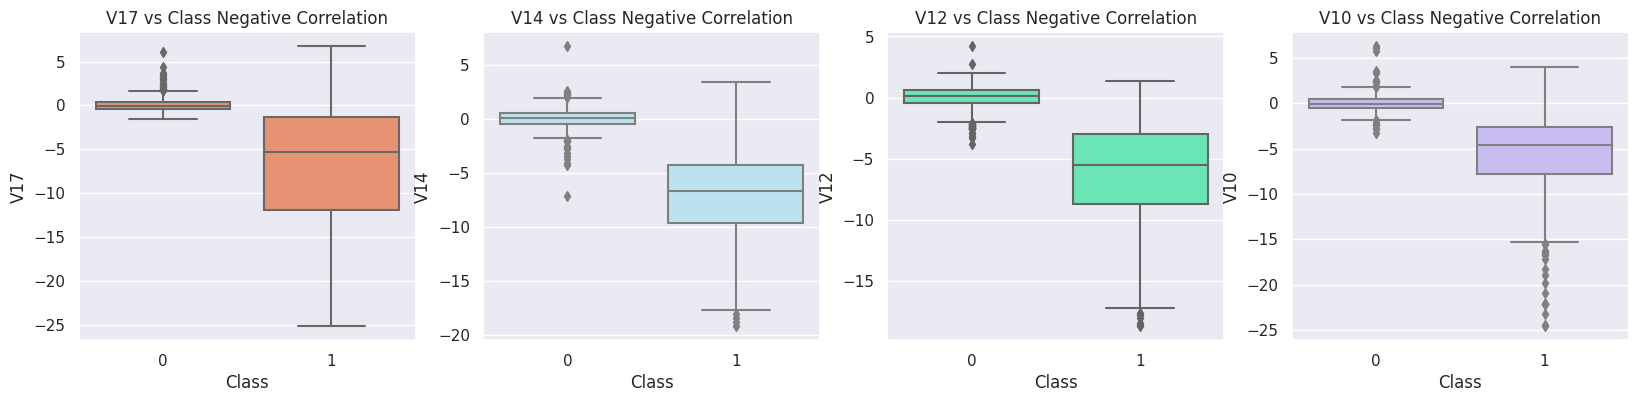

In [13]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, ax=axes[0], color='#FB8861')
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, ax=axes[1], color='#b3e5f9')
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, ax=axes[2], color='#56F9BB')
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, ax=axes[3], color='#C5B3F9')
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

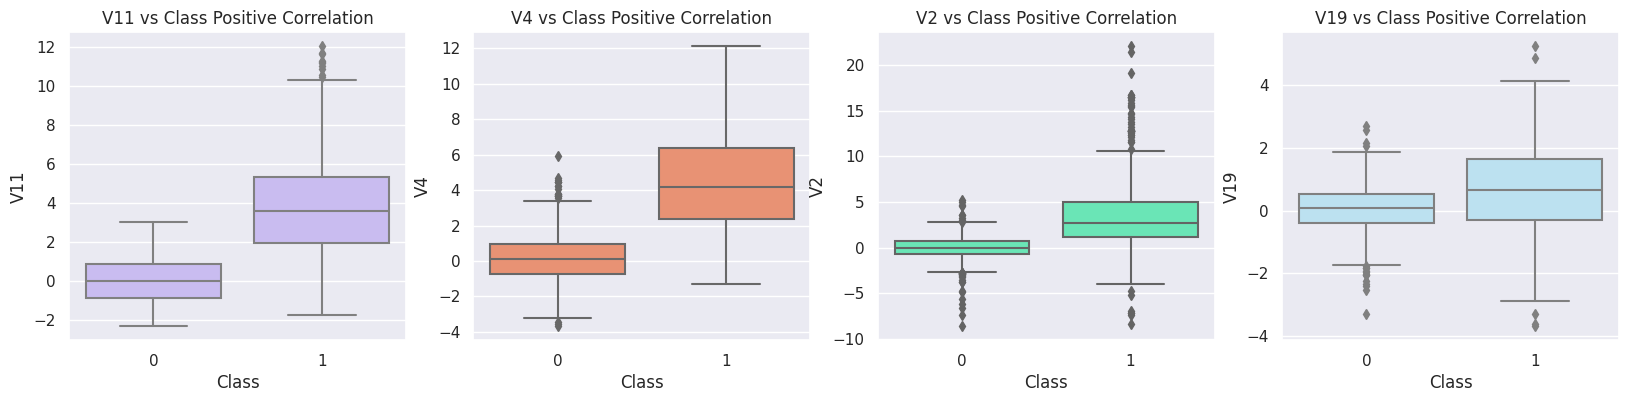

In [14]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, ax=axes[0], color='#C5B3F9')
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, ax=axes[1], color='#FB8861')
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, ax=axes[2], color='#56F9BB')
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, ax=axes[3], color='#b3e5f9')
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

### **Interquartile Range Method:**


* **Interquartile Range (IQR):** We calculate this by the difference between the 75th percentile and 25th percentile. Our aim is to create a threshold beyond the 75th and 25th percentile that in case some instance pass this threshold the instance will be deleted.
Boxplots: Besides easily seeing the 25th and 75th percentiles (both end of the squares) it is also easy to see extreme outliers (points beyond the lower and higher extreme).

* **Outlier Removal Tradeoff:** We have to be careful as to how far do we want the threshold for removing outliers. We determine the threshold by multiplying a number (ex: 1.5) by the (Interquartile Range). The higher this threshold is, the less outliers will detect (multiplying by a higher number ex: 3), and the lower this threshold is the more outliers it will detect.


* **The Tradeoff:** The lower the threshold the more outliers it will remove however, we want to focus more on "extreme outliers" rather than just outliers. Why? because we might run the risk of information loss which will cause our models to have a lower accuracy. You can play with this threshold and see how it affects the accuracy of our classification models.

# **Summary**

* **Visualize Distributions:** We first start by visualizing the distribution of the feature we are going to use to eliminate some of the outliers. V14 is the only feature that has a Gaussian distribution compared to features V12 and V10.

* **Determining the threshold:** After we decide which number we will use to multiply with the iqr (the lower more outliers removed), we will proceed in determining the upper and lower thresholds by substrating q25 - threshold (lower extreme threshold) and adding q75 + threshold (upper extreme threshold).

* **Conditional Dropping:** Lastly, we create a conditional dropping stating that if the "threshold" is exceeded in both extremes, the instances will be removed.
Boxplot Representation: Visualize through the boxplot that the number of "extreme outliers" have been reduced to a considerable amount.

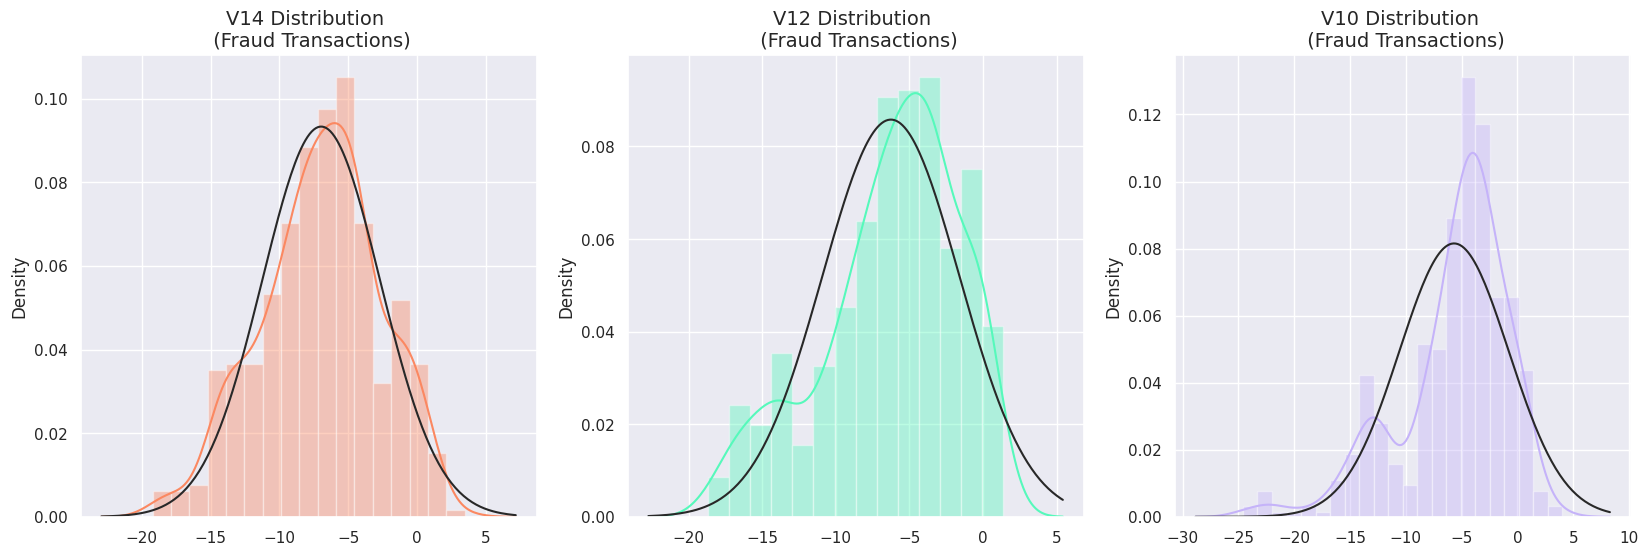

In [15]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

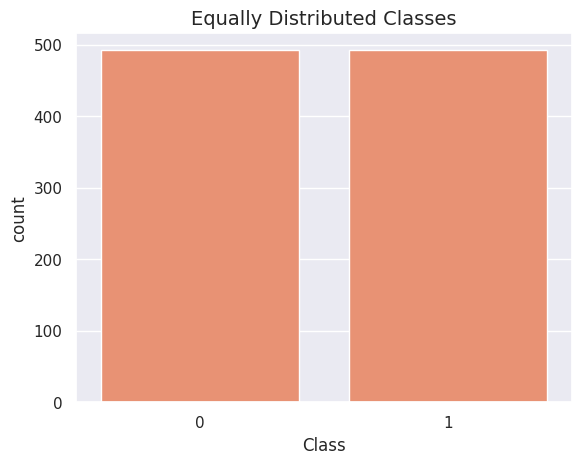

In [16]:
sns.countplot(data=new_df, x="Class", color='#FB8861')
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

### Dimensionality Reduction and Clustering:


In [17]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 2.7e+01 s
PCA took 0.019 s
Truncated SVD took 0.012 s


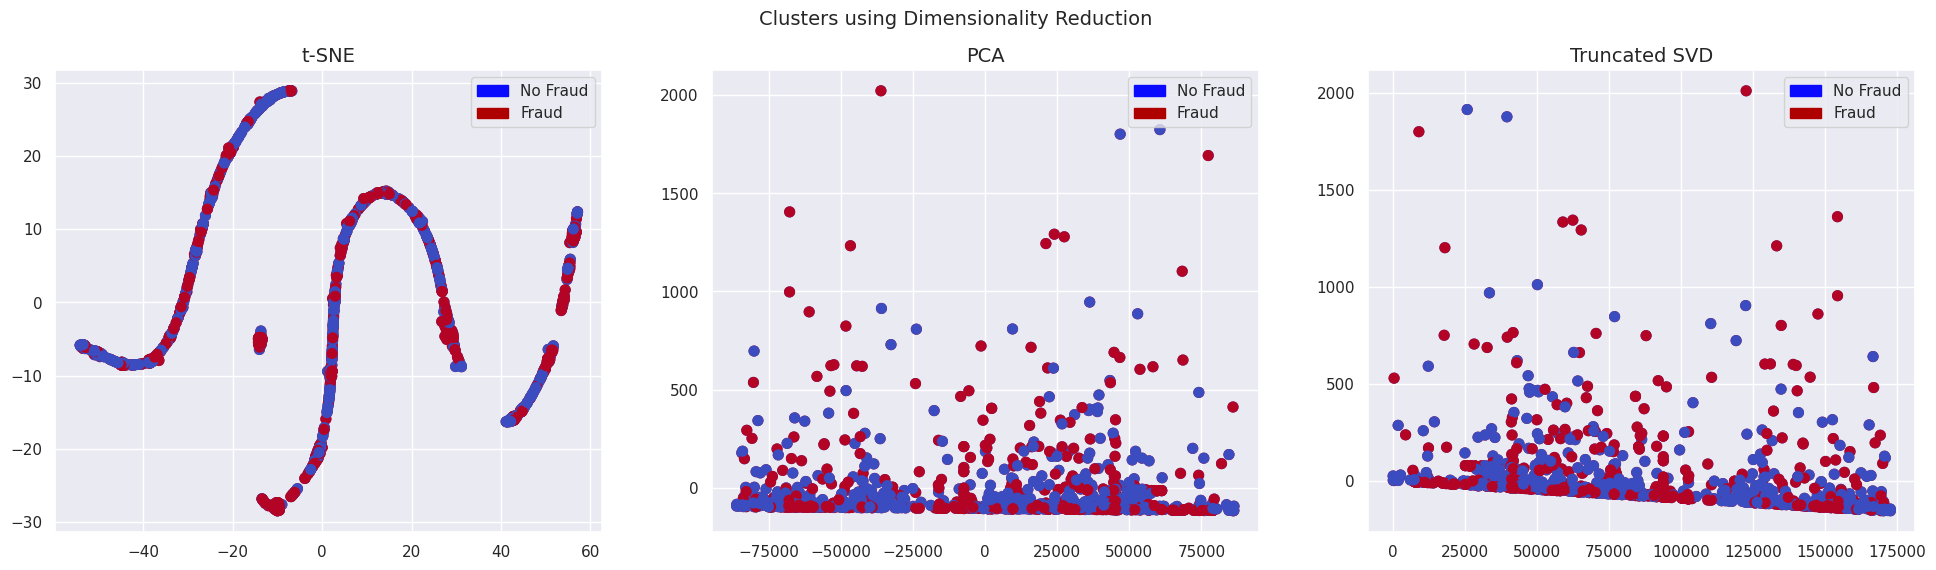

In [18]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()


# Classifiers (UnderSampling):

In this section we will train four types of classifiers and decide which classifier will be more effective in detecting fraud transactions. Before we have to split our data into training and testing sets and separate the features from the labels.

**Summary:**
* **Logistic Regression classifier** is more accurate than the other three classifiers in most cases. (We will further analyze Logistic Regression)
GridSearchCV is used to determine the paremeters that gives the best predictive score for the classifiers.

* Logistic Regression has the best Receiving Operating Characteristic score (ROC), meaning that LogisticRegression pretty accurately separates fraud and non-fraud transactions.

* **Learning Curves:** The wider the gap between the training score and the cross validation score, the more likely your model is overfitting (high variance).
If the score is low in both training and cross-validation sets this is an indication that our model is underfitting (high bias)
Logistic Regression Classifier shows the best score in both training and cross-validating sets.

In [19]:
new_df.shape

(984, 31)

In [20]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [21]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [22]:
# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 92.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 64.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 89.0 % accuracy score


In [23]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_


### Ploting Learning curve

In [24]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1,estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, (ax1, ax4) = plt.subplots(2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")


    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

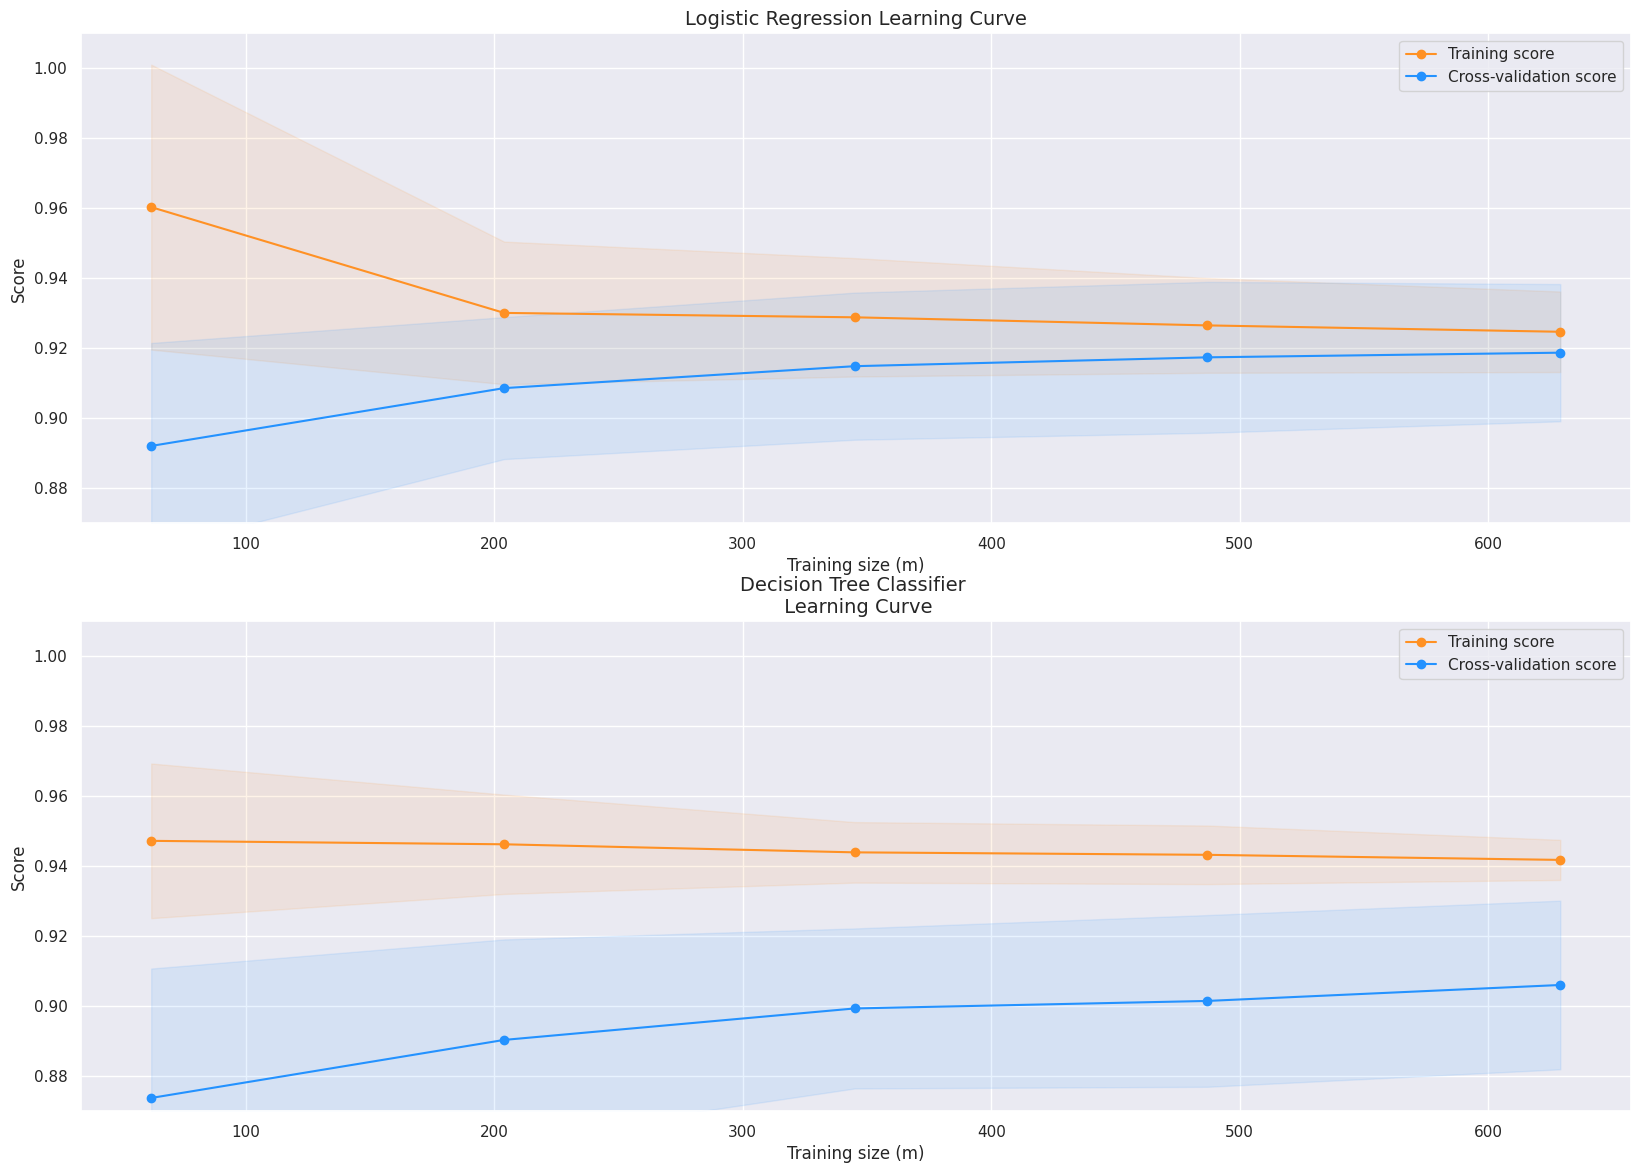

In [25]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)
plt.show()

### Roc Curve

In [26]:
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.962756124361709
KNears Neighbors:  0.618554068903109
Decision Tree Classifier:  0.903988106780428


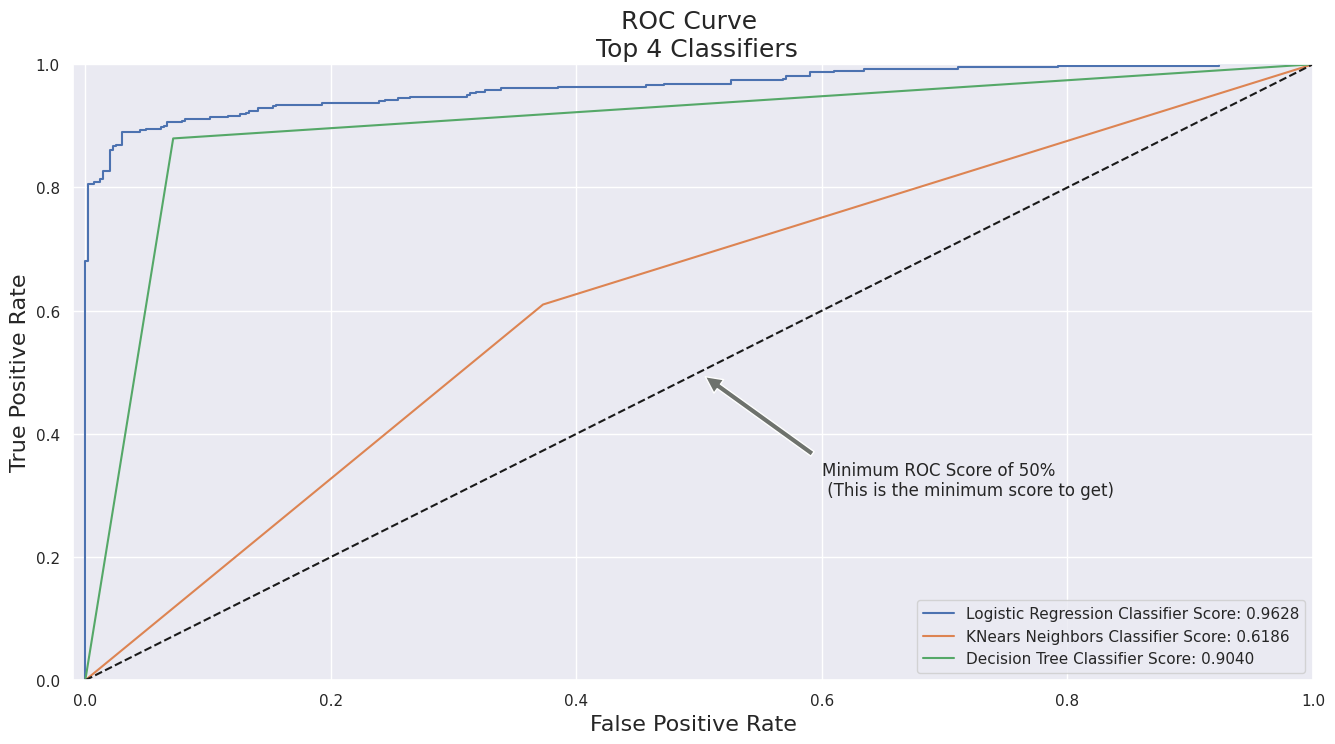

In [27]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()

graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, tree_fpr, tree_tpr)
plt.show()

### Logistic regression ROC Curve

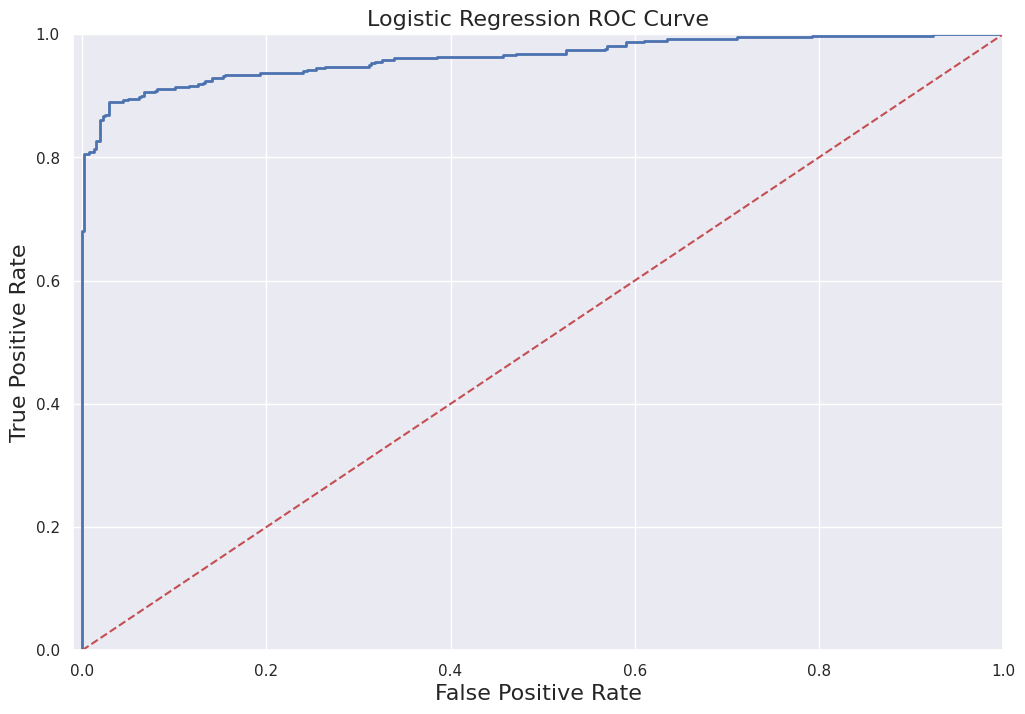

In [28]:

def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])


logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [29]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

# We will undersample during cross validating
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values

Train: [ 56959  56960  56961 ... 284804 284805 284806] Test: [    0     1     2 ... 57129 57180 57437]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56959  56960  56961 ... 113933 113934 113935]
Train: [     0      1      2 ... 284804 284805 284806] Test: [108550 109658 111053 ... 170888 170889 170890]
Train: [     0      1      2 ... 284804 284805 284806] Test: [168122 168794 169063 ... 227846 227847 227848]
Train: [     0      1      2 ... 227846 227847 227848] Test: [226954 227100 227604 ... 284804 284805 284806]


In [30]:
# We will undersample during cross validating
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []


for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(RandomUnderSampler(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])

    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 56959  56960  56961 ... 284804 284805 284806] Test: [    0     1     2 ... 57129 57180 57437]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56959  56960  56961 ... 113933 113934 113935]
Train: [     0      1      2 ... 284804 284805 284806] Test: [108550 109658 111053 ... 170888 170889 170890]
Train: [     0      1      2 ... 284804 284805 284806] Test: [168122 168794 169063 ... 227846 227847 227848]
Train: [     0      1      2 ... 227846 227847 227848] Test: [226954 227100 227604 ... 284804 284805 284806]


In [31]:
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

undersample_y_score = log_reg.decision_function(original_Xtest)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.91
Precision Score: 0.95
F1 Score: 0.93
Accuracy Score: 0.93
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.96
Precision Score: 0.04
Recall Score: 0.91
F1 Score: 0.08
---------------------------------------------------------------------------------------------------------------------------------------


# SMOTE Technique (Over-Sampling):

In [32]:

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

# Implementing SMOTE Technique
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])

    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9734952656010499
precision: 0.05588969227317041
recall: 0.8731905225576112
f1: 0.10491759064720423
---------------------------------------------------------------------------------------------------------------------------------------


In [33]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.97      0.99     56863
       Fraud       0.05      0.86      0.09        98

    accuracy                           0.97     56961
   macro avg       0.52      0.91      0.54     56961
weighted avg       1.00      0.97      0.98     56961



In [34]:
y_score = best_est.decision_function(original_Xtest)


In [35]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.70


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.70')

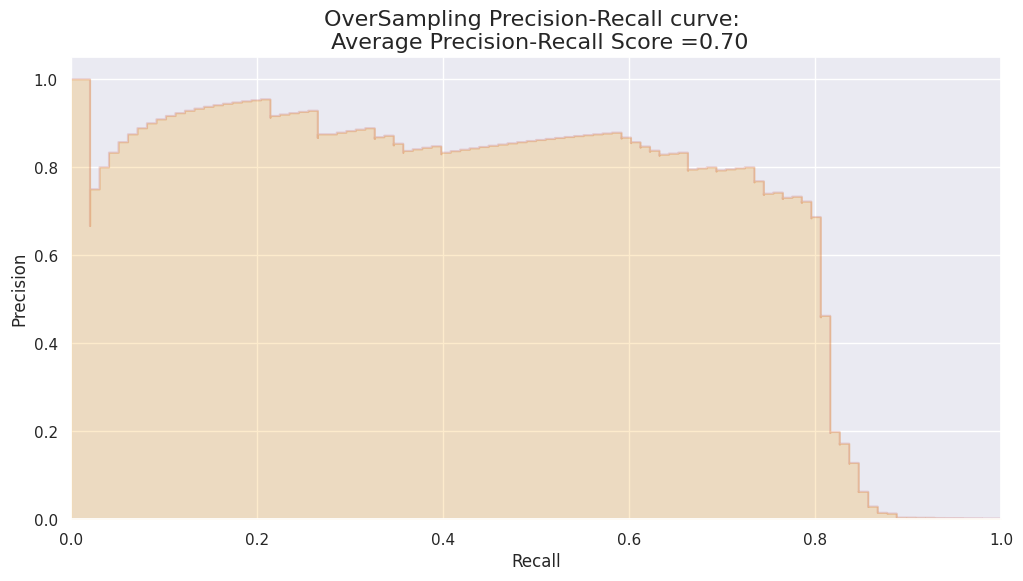

In [36]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [37]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [38]:
# We Improve the score by 2% points approximately
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :6.682884454727173 sec


**Test Data with Logistic Regression:**

**Confusion Matrix:**
* **Positive/Negative:** Type of Class (label) ["No", "Yes"] True/False: Correctly or Incorrectly classified by the model.


* **True Negatives (Top-Left Square):** This is the number of correctly classifications of the "No" (No Fraud Detected) class.


* **False Negatives (Top-Right Square):** This is the number of incorrectly classifications of the "No"(No Fraud Detected) class.


* **False Positives (Bottom-Left Square):** This is the number of incorrectly classifications of the "Yes" (Fraud Detected) class


* **True Positives (Bottom-Right Square):** This is the number of correctly classifications of the "Yes" (Fraud Detected) class.

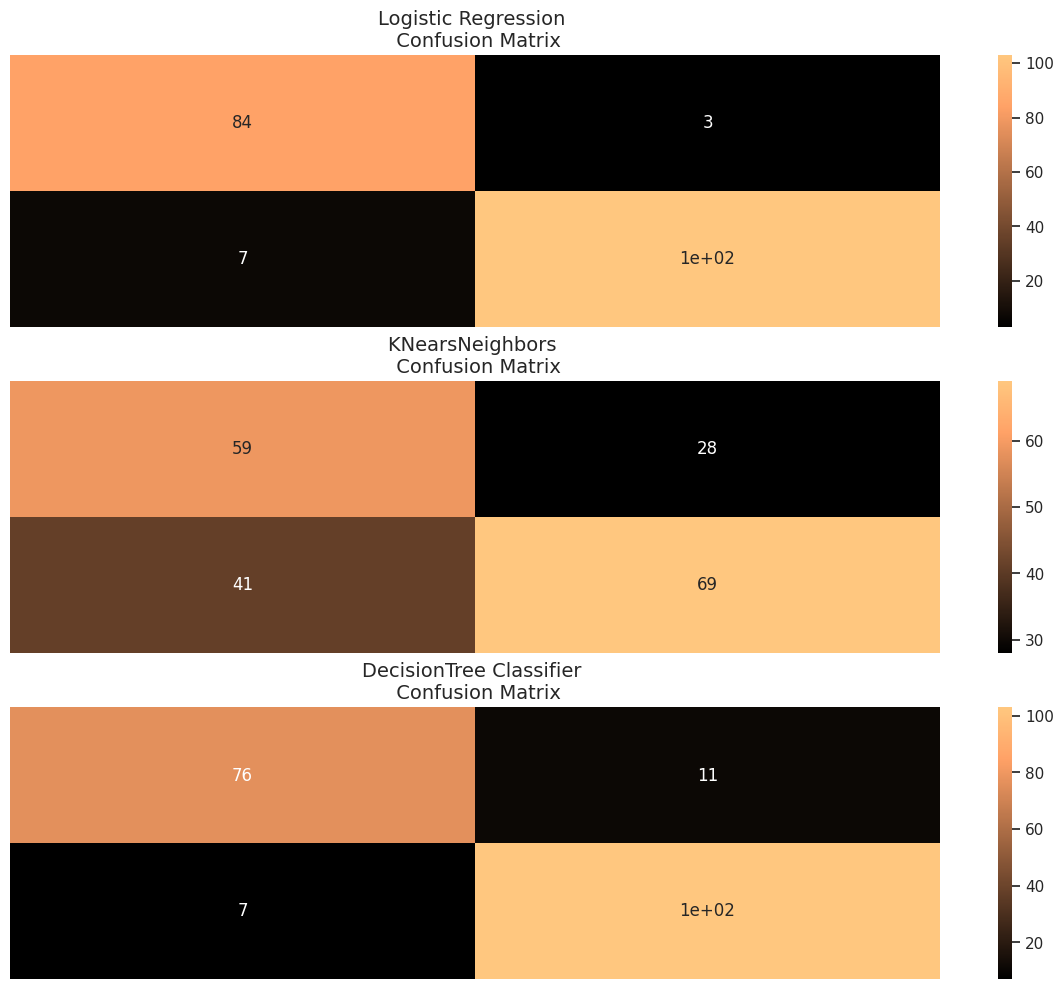

In [39]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(3,figsize=(15,12))

sns.heatmap(log_reg_cf, ax=ax[0], annot=True, cmap=plt.cm.copper)
ax[0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[1], annot=True, cmap=plt.cm.copper)
ax[1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[2], annot=True, cmap=plt.cm.copper)
ax[2].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[2].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[2].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [40]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)



# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading!
final_df

,Technique,Score
0,Random UnderSampling,0.949239
1,Oversampling (SMOTE),0.971015


# Keras | UnderSampling

In [41]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

   # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [42]:

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [43]:
undersample_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 32)                992       
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [44]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
26/26 - 4s - loss: 1767.4126 - accuracy: 0.4833 - val_loss: 290.6996 - val_accuracy: 0.5063 - 4s/epoch - 155ms/step
Epoch 2/20
26/26 - 0s - loss: 183.1551 - accuracy: 0.5103 - val_loss: 19.0576 - val_accuracy: 0.5380 - 83ms/epoch - 3ms/step
Epoch 3/20
26/26 - 0s - loss: 121.6172 - accuracy: 0.5072 - val_loss: 193.1208 - val_accuracy: 0.5063 - 84ms/epoch - 3ms/step
Epoch 4/20
26/26 - 0s - loss: 155.3499 - accuracy: 0.5246 - val_loss: 40.3047 - val_accuracy: 0.5190 - 94ms/epoch - 4ms/step
Epoch 5/20
26/26 - 0s - loss: 194.0369 - accuracy: 0.5072 - val_loss: 119.7393 - val_accuracy: 0.4873 - 92ms/epoch - 4ms/step
Epoch 6/20
26/26 - 0s - loss: 53.7561 - accuracy: 0.5660 - val_loss: 126.8229 - val_accuracy: 0.4810 - 101ms/epoch - 4ms/step
Epoch 7/20
26/26 - 0s - loss: 84.3584 - accuracy: 0.5135 - val_loss: 63.6085 - val_accuracy: 0.5316 - 102ms/epoch - 4ms/step
Epoch 8/20
26/26 - 0s - loss: 67.7399 - accuracy: 0.5437 - val_loss: 24.1293 - val_accuracy: 0.5759 - 90ms/epoch - 3ms/s

Confusion matrix, without normalization
Confusion matrix, without normalization


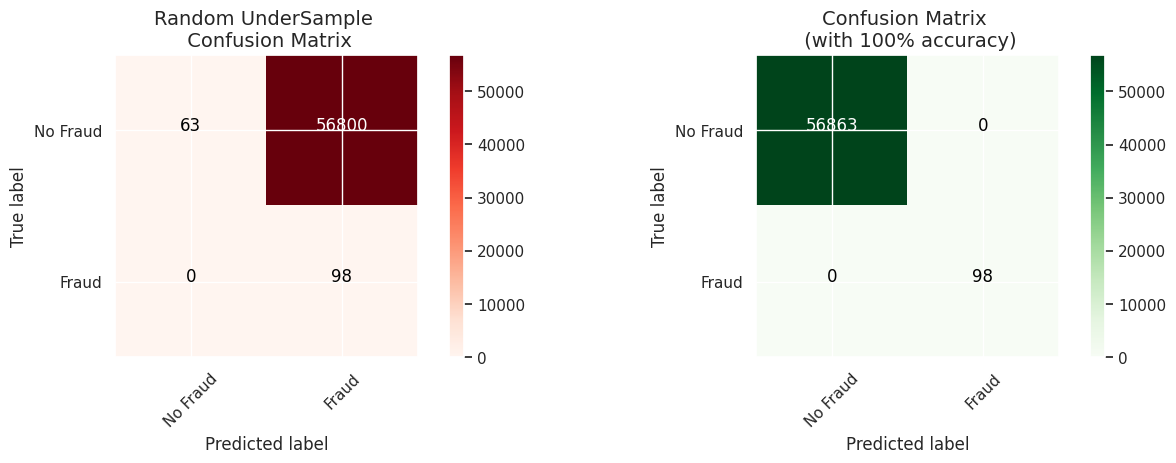

In [45]:

# Use predict to obtain probabilities
undersample_fraud_probabilities = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

# Convert predicted probabilities to binary labels (0 or 1) using threshold
threshold = 0.5
undersample_fraud_predictions = (undersample_fraud_probabilities >= threshold).astype(int)

# Compute confusion matrix for undersample_fraud_predictions
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions[:, 1])


actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(13,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

# Keras || OverSampling (SMOTE):

In [46]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
1214/1214 - 5s - loss: 35.3629 - accuracy: 0.6323 - val_loss: 0.0024 - val_accuracy: 0.9997 - 5s/epoch - 4ms/step
Epoch 2/20
1214/1214 - 3s - loss: 11.2627 - accuracy: 0.7414 - val_loss: 37.1865 - val_accuracy: 0.4990 - 3s/epoch - 3ms/step
Epoch 3/20
1214/1214 - 3s - loss: 7.1566 - accuracy: 0.8155 - val_loss: 18.2490 - val_accuracy: 0.6092 - 3s/epoch - 3ms/step
Epoch 4/20
1214/1214 - 3s - loss: 6.8112 - accuracy: 0.8388 - val_loss: 1.4775 - val_accuracy: 0.9086 - 3s/epoch - 2ms/step
Epoch 5/20
1214/1214 - 4s - loss: 4.1068 - accuracy: 0.8873 - val_loss: 4.7060e-07 - val_accuracy: 1.0000 - 4s/epoch - 3ms/step
Epoch 6/20
1214/1214 - 3s - loss: 3.9079 - accuracy: 0.9010 - val_loss: 0.6728 - val_accuracy: 0.9510 - 3s/epoch - 3ms/step
Epoch 7/20
1214/1214 - 3s - loss: 5.3244 - accuracy: 0.8843 - val_loss: 30.1448 - val_accuracy: 0.6502 - 3s/epoch - 2ms/step
Epoch 8/20
1214/1214 - 3s - loss: 3.0101 - accuracy: 0.9228 - val_loss: 0.6449 - val_accuracy: 0.9593 - 3s/epoch - 2ms/step

Confusion matrix, without normalization
Confusion matrix, without normalization


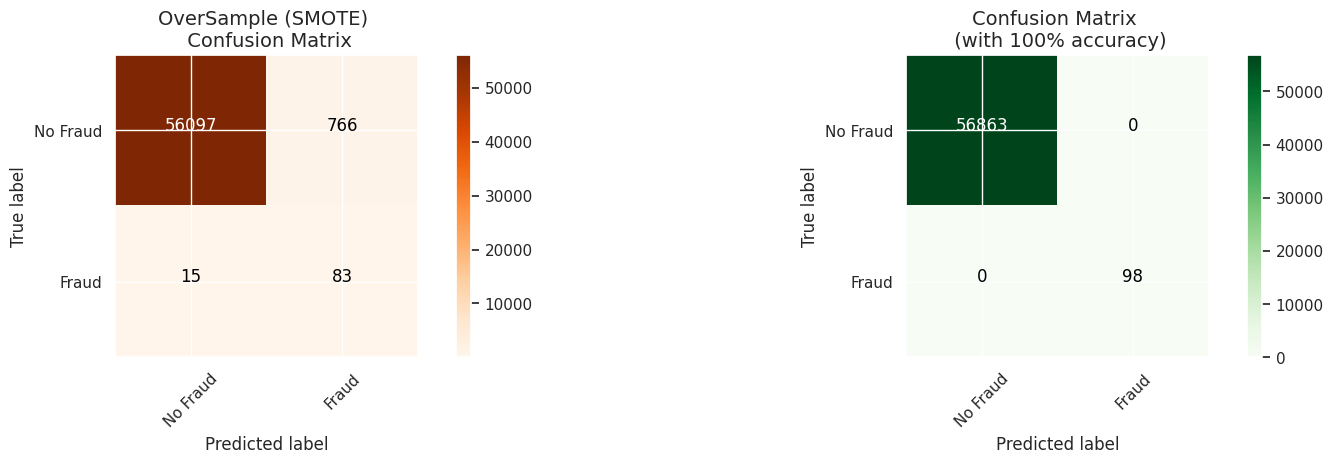

In [47]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

threshold = 0.5
oversample_fraud_predictions = (oversample_predictions >= threshold).astype(int)


oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions[:, 1])
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

 **Implementing SMOTE on our imbalanced dataset helped us with the imbalance of our labels (more no fraud than fraud transactions).**